## Chapter 19 - Metric Predicted Variable with One Nominal Predictor

- [19.3 - Hierarchical Bayesian Approach](#19.3---Hierarchical-Bayesian-Approach)
- [19.4 - Adding a Metric Predictor](#19.4---Adding-a-Metric-Predictor)
- [19.5 - Heterogeneous Variances and Robustness against Outliers](#19.5---Heterogeneous-Variances-and-Robustness-against-Outliers)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.stats import norm
from IPython.display import Image
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,theano,matplotlib,seaborn,scipy

pandas 0.23.4
numpy 1.15.1
pymc3 3.5
theano 1.0.2
matplotlib 2.2.3
seaborn 0.9.0
scipy 1.1.0


In [3]:
def gammaShRaFromModeSD(mode, sd):
    """Calculate Gamma shape and rate from mode and sd."""
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [4]:
def plot_mustache(var, sd, j, axis, width=.75):
    for i in np.arange(start=0, stop=len(var), step=int(len(var)*.1)):
        rv = norm(loc=var[i], scale=sd[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)
        
        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange*(width/xrange.max())
        
        # Using the negative value to flip the mustache in the right direction.
        axis.plot(-xrange_scaled+j, yrange, color=color, alpha=.6)

In [5]:
def plot_cred_lines(b0, bj, bcov, x, ax):
    """Plot credible posterior distribution lines for model in section 19.4"""
   
    B = pd.DataFrame(np.c_[b0, bj, bcov], columns=['beta0', 'betaj', 'betacov'])
    
    # Credible posterior prediction lines
    hpd_interval = pm.hpd(B.values, alpha=0.05)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & 
              B.betaj.between(*hpd_interval[1,:]) &
              B.betacov.between(*hpd_interval[2,:])] 
    xrange = np.linspace(x.min()*.95, x.max()*1.05)
   
    for i in np.random.randint(0, len(B_hpd), 10):
        ax.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]+B_hpd.iloc[i,2]*xrange, c=color, alpha=.6, zorder=0)    

### 19.3 - Hierarchical Bayesian Approach

In [6]:
df = pd.read_csv('data/FruitflyDataReduced.csv', dtype={'CompanionNumber':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
Longevity          125 non-null int64
CompanionNumber    125 non-null category
Thorax             125 non-null float64
dtypes: category(1), float64(1), int64(1)
memory usage: 2.3 KB


In [7]:
df.groupby('CompanionNumber').head(2)

,Longevity,CompanionNumber,Thorax
0,35,Pregnant8,0.64
1,37,Pregnant8,0.68
25,40,None0,0.64
26,37,None0,0.70
50,46,Pregnant1,0.64
51,42,Pregnant1,0.68
75,21,Virgin1,0.68
76,40,Virgin1,0.68
100,16,Virgin8,0.64
101,19,Virgin8,0.64


In [8]:
# Count the number of records per nominal group
df.CompanionNumber.value_counts()

Virgin8      25
Virgin1      25
Pregnant8    25
Pregnant1    25
None0        25
Name: CompanionNumber, dtype: int64

#### Model (Kruschke, 2015)

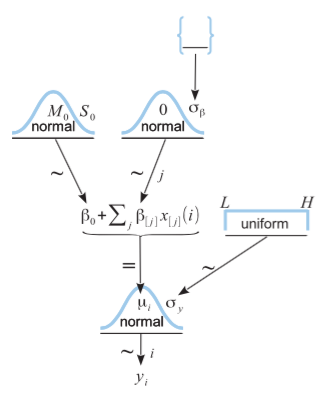

In [9]:
Image('images/fig19_2.png')

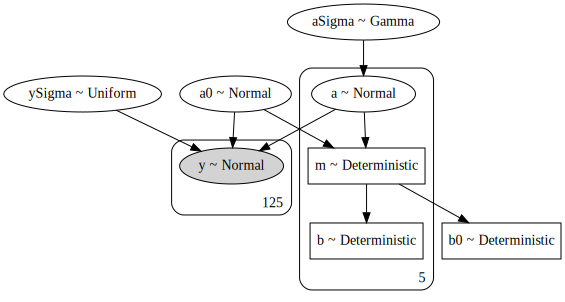

In [10]:
x = df.CompanionNumber.cat.codes.values
y = df.Longevity
yMean = y.mean()
ySD = y.std()

NxLvl = len(df.CompanionNumber.cat.categories)

agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pm.Model() as model1:
    
    aSigma = pm.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
       
    ySigma = pm.Uniform('ySigma', ySD/100, ySD*10)
    y = pm.Normal('y', a0 + a[x], tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pm.Deterministic('m', a0 + a)
    b0 = pm.Deterministic('b0', tt.mean(m))
    b = pm.Deterministic('b', m - b0) 

pm.model_to_graphviz(model1)

In [11]:
with model1:
    trace1 = pm.sample(3000, cores=4, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ySigma, a, a0, aSigma]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:14<00:00, 983.22draws/s] 
The number of effective samples is smaller than 25% for some parameters.


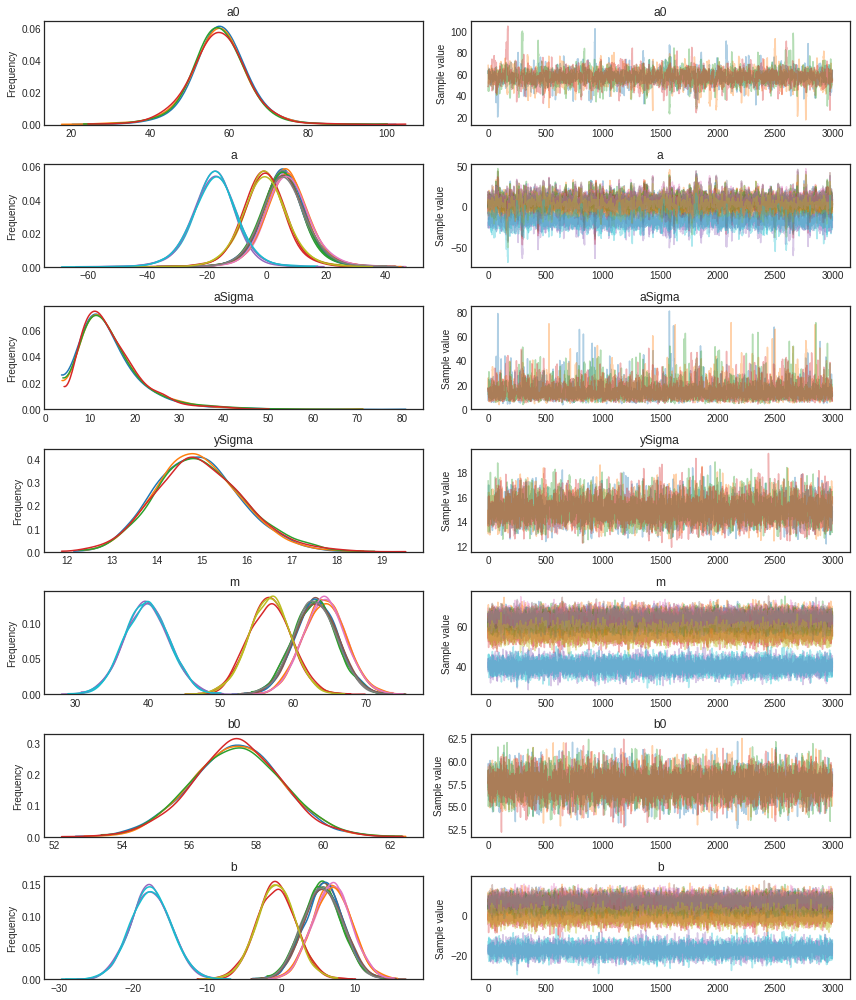

In [12]:
pm.traceplot(trace1);

#### Figure 19.3 (top)

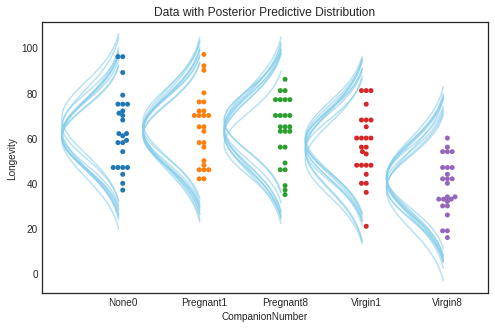

In [13]:
# Here we plot the metric predicted variable for each group. Then we superimpose the 
# posterior predictive distribution

None0 = trace1['m'][:,0]
Pregnant1 = trace1['m'][:,1]
Pregnant8 = trace1['m'][:,2]
Virgin1 = trace1['m'][:,3]
Virgin8 = trace1['m'][:,4]
scale = trace1['ySigma'][:]

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.set_title('Data with Posterior Predictive Distribution')

sns.swarmplot('CompanionNumber', 'Longevity', data=df, ax=ax);
ax.set_xlim(xmin=-1)

for i, grp in enumerate([None0, Pregnant1, Pregnant8, Virgin1, Virgin8]):
    plot_mustache(grp, scale, i, ax)

#### Contrasts

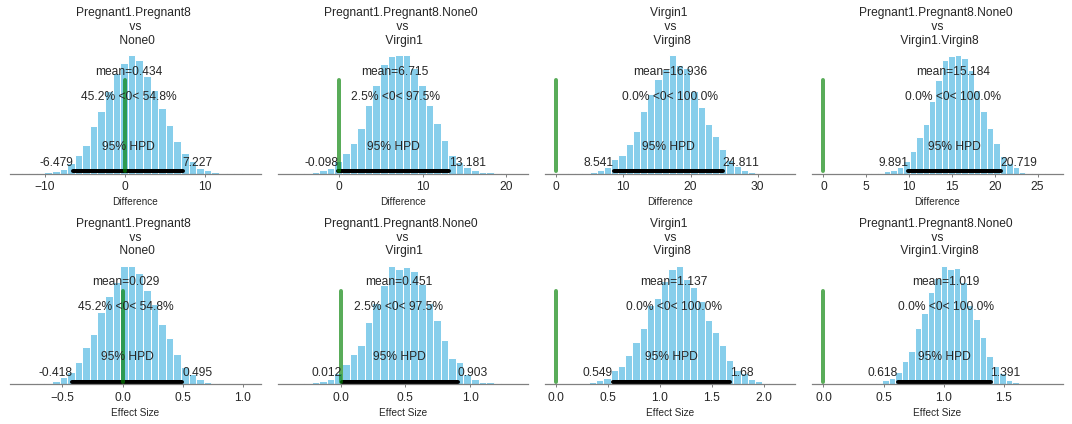

In [14]:
fig, axes = plt.subplots(2,4, figsize=(15,6))

contrasts = [np.mean([Pregnant1, Pregnant8], axis=0)-None0,
             np.mean([Pregnant1, Pregnant8, None0], axis=0)-Virgin1,
             Virgin1-Virgin8,
             np.mean([Pregnant1, Pregnant8, None0], axis=0)-np.mean([Virgin1, Virgin8], axis=0)]

contrast_titles = ['Pregnant1.Pregnant8 \n vs \n None0',
                   'Pregnant1.Pregnant8.None0 \n vs \n Virgin1',
                   'Virgin1 \n vs \n Virgin8',
                   'Pregnant1.Pregnant8.None0 \n vs \n Virgin1.Virgin8']

for contr, ctitle, ax_top, ax_bottom in zip(contrasts, contrast_titles, fig.axes[:4], fig.axes[4:]):
    pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_top)
    pm.plot_posterior(contr/scale, ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
fig.tight_layout()

### 19.4 - Adding a Metric Predictor

#### Model (Kruschke, 2015)

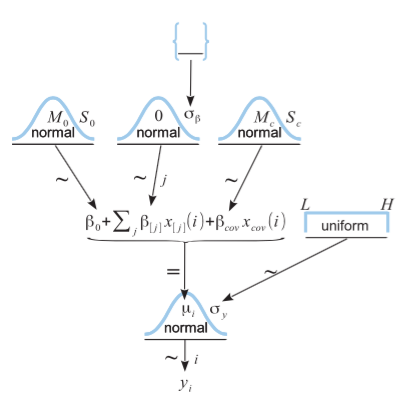

In [15]:
Image('images/fig19_4.png')

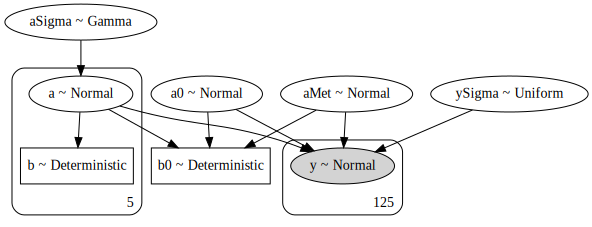

In [16]:
y = df.Longevity
yMean = y.mean()
ySD = y.std()
xNom = df.CompanionNumber.cat.categories
xMet = df.Thorax
xMetMean = df.Thorax.mean()
xMetSD = df.Thorax.std()
NxNomLvl = len(df.CompanionNumber.cat.categories)

X = pd.concat([df.Thorax, pd.get_dummies(df.CompanionNumber, drop_first=True)], axis=1)
lmInfo = LinearRegression().fit(X, y)
residSD = np.sqrt(mean_squared_error(y, lmInfo.predict(X)))

agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pm.Model() as model2:
    
    aSigma = pm.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=NxNomLvl)
    aMet = pm.Normal('aMet', 0, tau=1/(2*ySD/xMetSD)**2)
       
    ySigma = pm.Uniform('ySigma', residSD/100, ySD*10)
    
    mu = a0 + a[x] + aMet*(xMet - xMetMean)
    y = pm.Normal('y', mu, tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    b0 = pm.Deterministic('b0', a0 + tt.mean(a) + aMet*(-xMetMean))
    b = pm.Deterministic('b', a - tt.mean(a))

pm.model_to_graphviz(model2)

In [17]:
with model2:
    trace2 = pm.sample(3000, cores=4, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ySigma, aMet, a, a0, aSigma]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:18<00:00, 761.72draws/s]
The number of effective samples is smaller than 25% for some parameters.


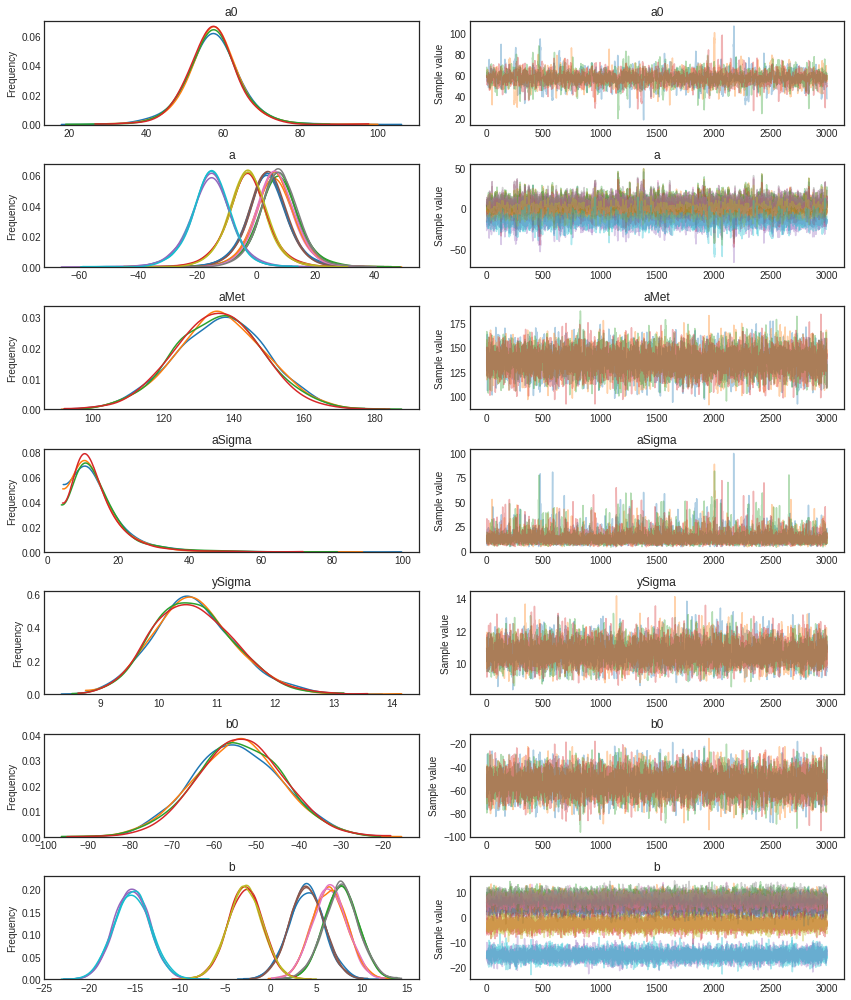

In [18]:
pm.traceplot(trace2);

#### Figure 19.5

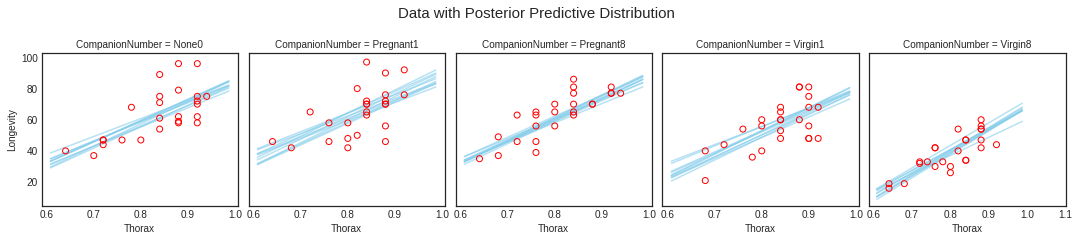

In [19]:
# Here we plot, for every group, the predicted variable and the metric predictor.
# Superimposed are are the posterior predictive distributions.
fg = sns.FacetGrid(df, col='CompanionNumber', despine=False)
fg.map(plt.scatter, 'Thorax', 'Longevity', facecolor='none', edgecolor='r')

plt.suptitle('Data with Posterior Predictive Distribution', y=1.10, fontsize=15)
for i, ax in enumerate(fg.axes.flatten()):
    plot_cred_lines(trace2['b0'],
                    trace2['b'][:,i],
                    trace2['aMet'][:],
                    xMet, ax)
    ax.set_xticks(np.arange(.6, 1.1, .1));

#### Contrasts

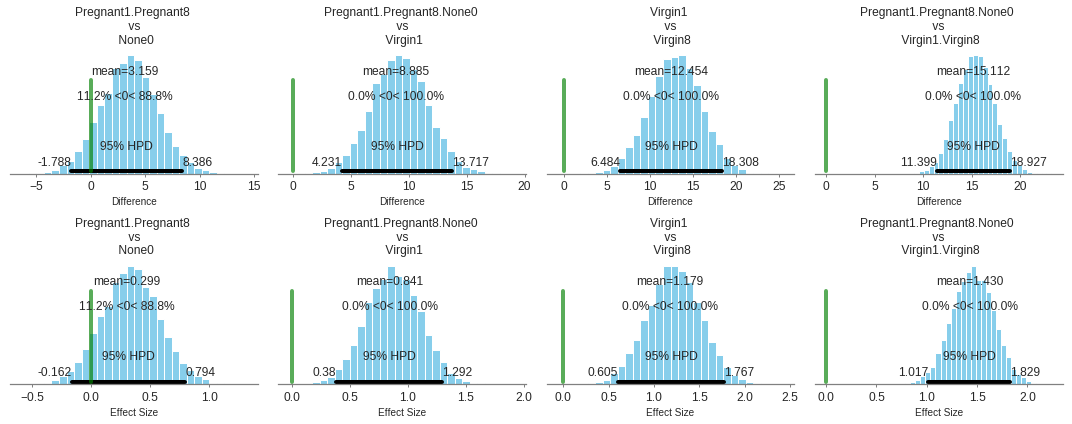

In [20]:
None0 = trace2['b'][:,0]
Pregnant1 = trace2['b'][:,1]
Pregnant8 = trace2['b'][:,2]
Virgin1 = trace2['b'][:,3]
Virgin8 = trace2['b'][:,4]
scale = trace2['ySigma']

fig, axes = plt.subplots(2,4, figsize=(15,6))

contrasts = [np.mean([Pregnant1, Pregnant8], axis=0)-None0,
             np.mean([Pregnant1, Pregnant8, None0], axis=0)-Virgin1,
             Virgin1-Virgin8,
             np.mean([Pregnant1, Pregnant8, None0], axis=0)-np.mean([Virgin1, Virgin8], axis=0)]

for contr, ctitle, ax_top, ax_bottom in zip(contrasts, contrast_titles, fig.axes[:4], fig.axes[4:]):
    pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_top)
    pm.plot_posterior(contr/scale, ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
fig.tight_layout()

### 19.5 - Heterogeneous Variances and Robustness against Outliers

In [21]:
df2 = pd.read_csv('data/NonhomogVarData.csv', dtype={'Group':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
Group    96 non-null category
Y        96 non-null float64
dtypes: category(1), float64(1)
memory usage: 976.0 bytes


In [22]:
df2.groupby('Group').head(3)

,Group,Y
0,A,97.770214
1,A,99.919872
2,A,92.372917
24,B,98.246778
25,B,98.736006
26,B,98.722708
48,C,102.432580
49,C,102.198665
50,C,103.052658
72,D,97.561346


#### Model (Kruschke, 2015)

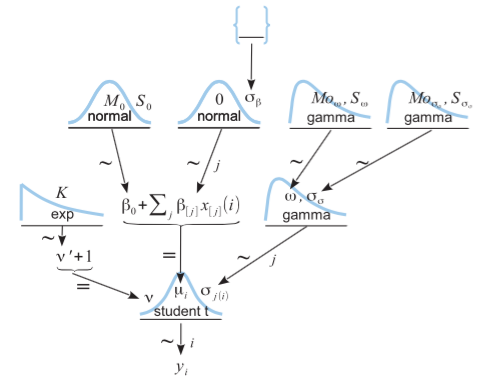

In [23]:
Image('images/fig19_6.png')

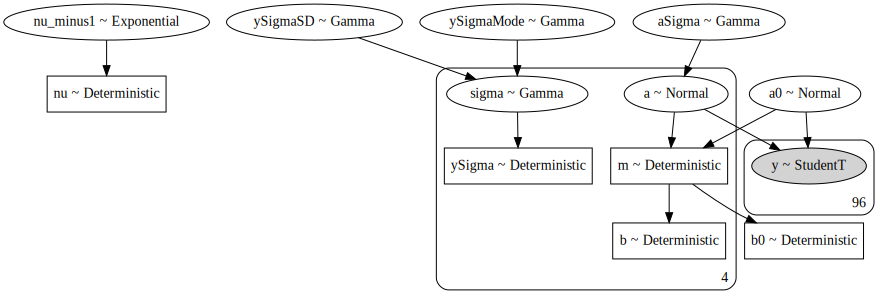

In [24]:
y = df2.Y
x = df2.Group.cat.codes.values
xlevels = df2.Group.cat.categories
NxLvl = len(xlevels) 
yMean = y.mean()
ySD = y.std()

aGammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)
medianCellSD = df2.groupby('Group').std().dropna().median()

with pm.Model() as model3:
    
    aSigma = pm.Gamma('aSigma', aGammaShRa[0], aGammaShRa[1])
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*10)**2)
    a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
    
    ySigmaSD = pm.Gamma('ySigmaSD', aGammaShRa[0], aGammaShRa[1])
    ySigmaMode = pm.Gamma('ySigmaMode', aGammaShRa[0], aGammaShRa[1])
    ySigmaRa = (ySigmaMode + np.sqrt(ySigmaMode**2 + 4*ySigmaSD**2))/2*ySigmaSD**2
    ySigmaSh = ySigmaMode*ySigmaRa
        
    sigma = pm.Gamma('sigma', ySigmaSh, ySigmaRa, shape=NxLvl)
    ySigma = pm.Deterministic('ySigma', tt.maximum(sigma, medianCellSD/1000))
    nu_minus1 = pm.Exponential('nu_minus1', 1/29.)
    nu = pm.Deterministic('nu', nu_minus1+1)
    like = pm.StudentT('y', nu=nu, mu=a0 + a[x], sd=ySigma[x], observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pm.Deterministic('m', a0 + a)
    b0 = pm.Deterministic('b0', tt.mean(m))
    b = pm.Deterministic('b', m - b0)

pm.model_to_graphviz(model3)

In [30]:
with model3:
    # Initializing NUTS with advi since jitter seems to create a problem in this model.
    # https://github.com/pymc-devs/pymc3/issues/2897
    trace3 = pm.sample(3000, init='advi+adapt_diag', cores=4, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 268.21:  14%|█▍        | 28661/200000 [00:10<01:03, 2707.41it/s]   
Convergence achieved at 28900
Interrupted at 28,899 [14%]: Average Loss = 30,887
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus1, sigma, ySigmaMode, ySigmaSD, a, a0, aSigma]
Sampling 4 chains: 100%|██████████| 14000/14000 [01:16<00:00, 183.03draws/s]
The number of effective samples is smaller than 25% for some parameters.


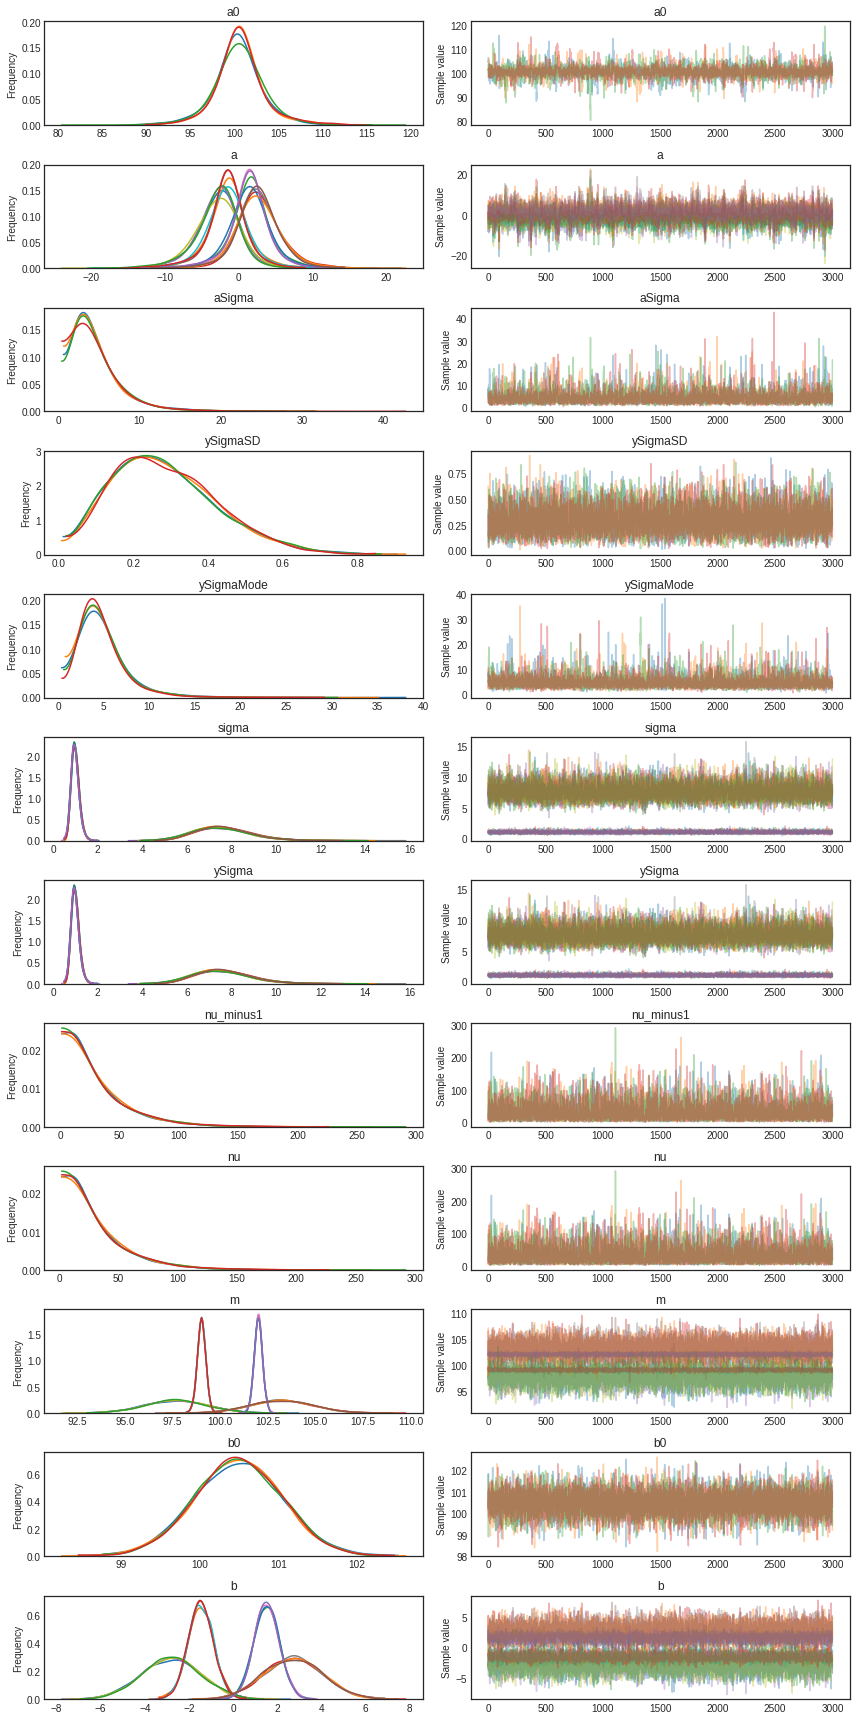

In [31]:
pm.traceplot(trace3);

#### Model that assumes equal variances

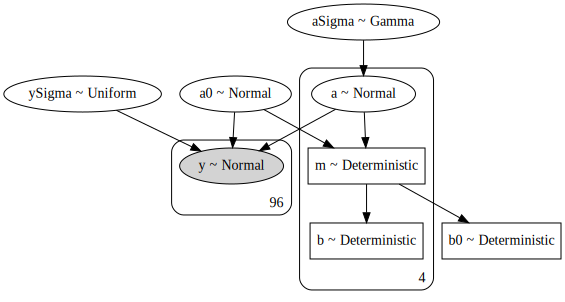

In [32]:
y = df2.Y
x = df2.Group.cat.codes.values
xlevels = df2.Group.cat.categories
NxLvl = len(xlevels) 
yMean = y.mean()
ySD = y.std()

aGammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pm.Model() as model3b:
    
    aSigma = pm.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
       
    ySigma = pm.Uniform('ySigma', ySD/100, ySD*10)
    y = pm.Normal('y', a0 + a[x], tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pm.Deterministic('m', a0 + a)
    b0 = pm.Deterministic('b0', tt.mean(m))
    b = pm.Deterministic('b', m - b0)
    
pm.model_to_graphviz(model3b)

In [33]:
with model3b:
    trace3b = pm.sample(3000, cores=4, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ySigma, a, a0, aSigma]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:19<00:00, 723.93draws/s] 
The number of effective samples is smaller than 25% for some parameters.


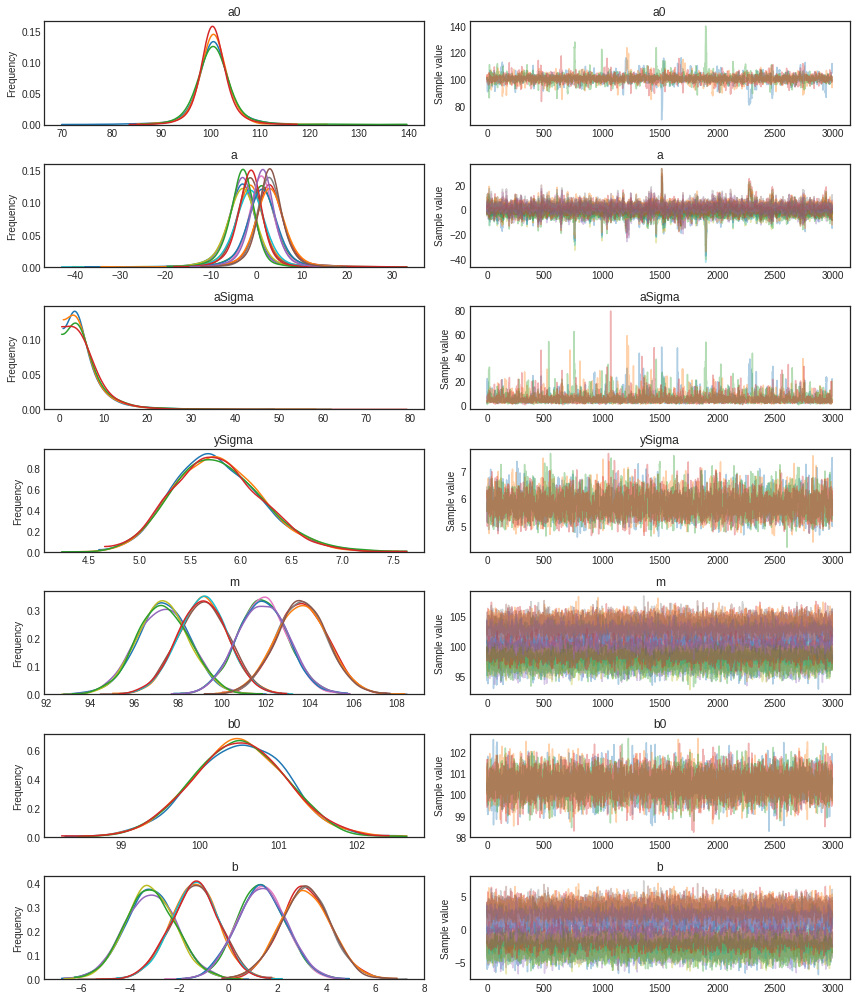

In [34]:
pm.traceplot(trace3b);

#### Figure 19.7

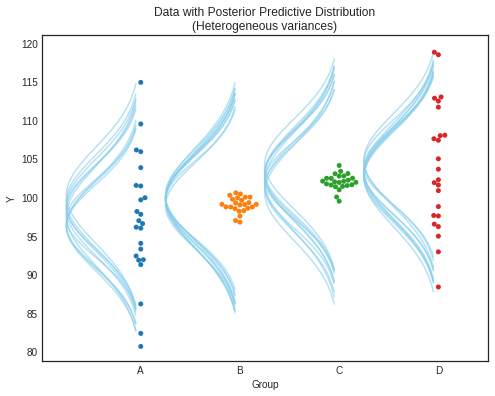

In [35]:
group_a = trace3b['m'][:,0]
group_b = trace3b['m'][:,1]
group_c = trace3b['m'][:,2]
group_d = trace3b['m'][:,3]
scale = trace3b['ySigma']
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.set_title('Data with Posterior Predictive Distribution\n(Heterogeneous variances)')

sns.swarmplot('Group', 'Y', data=df2, size=5, ax=ax)
ax.set_xlim(xmin=-1);

for i, grp, in enumerate([group_a, group_b, group_c, group_d]):
    plot_mustache(grp, scale, i, ax)

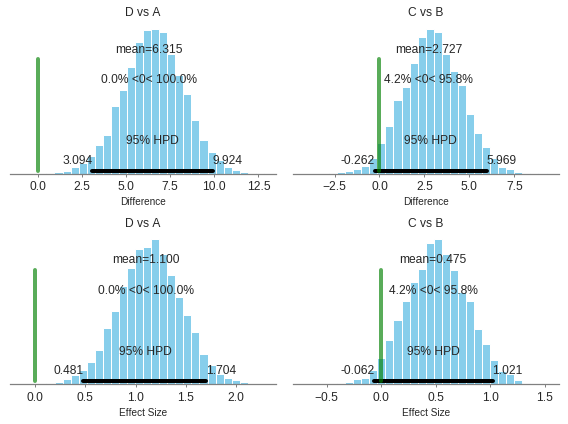

In [36]:
fig, axes = plt.subplots(2,2, figsize=(8,6))

contrasts = [group_d-group_a,
             group_c-group_b]

contrast_titles = ['D vs A',
                   'C vs B']

for contr, ctitle, ax_top, ax_bottom in zip(contrasts, contrast_titles, fig.axes[:2], fig.axes[2:]):
    pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_top)
    pm.plot_posterior(contr/scale, ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
fig.tight_layout()

#### Figure 19.8

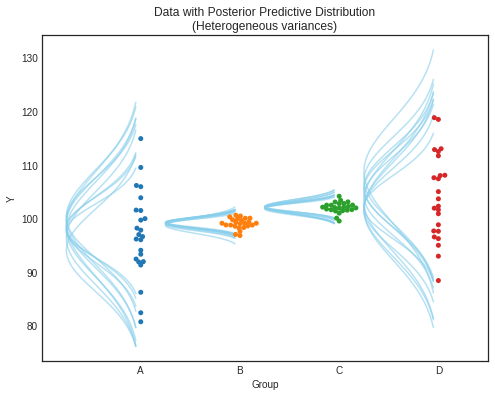

In [37]:
group_a = trace3['m'][:,0]
group_b = trace3['m'][:,1]
group_c = trace3['m'][:,2]
group_d = trace3['m'][:,3]
scale_a = trace3['ySigma'][:,0]
scale_b = trace3['ySigma'][:,1]
scale_c = trace3['ySigma'][:,2]
scale_d = trace3['ySigma'][:,3]

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.set_title('Data with Posterior Predictive Distribution\n(Heterogeneous variances)')

sns.swarmplot('Group', 'Y', data=df2, size=5, ax=ax)
ax.set_xlim(xmin=-1);

for i, (grp, scale) in enumerate(zip([group_a, group_b, group_c, group_d],
                                     [scale_a, scale_b, scale_c, scale_d])):
    plot_mustache(grp, scale, i, ax)

#### Contrasts

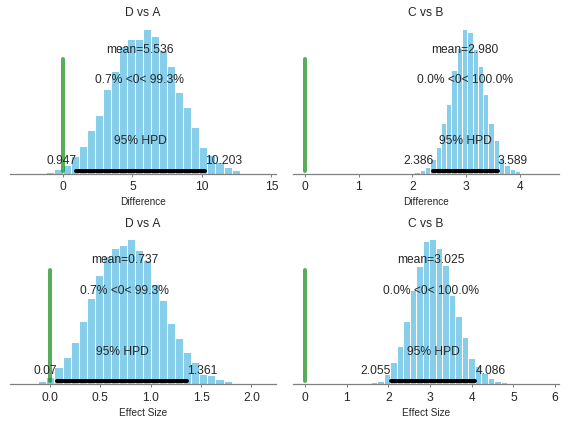

In [38]:
fig, axes = plt.subplots(2,2, figsize=(8,6))

contrasts = [group_d-group_a,
             group_c-group_b]

scales = [scale_d**2 + scale_a**2,
         scale_c**2 + scale_b**2]

contrast_titles = ['D vs A',
                   'C vs B']

for contr, scale, ctitle, ax_top, ax_bottom in zip(contrasts, scales, contrast_titles, fig.axes[:2], fig.axes[2:]):
    pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_top)
    pm.plot_posterior(contr/(np.sqrt(scale/2)), ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
fig.tight_layout()